In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.plotting import adjust_plot_1d
from lib.simdata_i3 import I3SimHandler
import pandas as pd

In [2]:
bp = '/home/storage/hans/jax_reco_gupta_corrections/examples/reco_lowE/results/'

# starting events
# [8, 1722, 9410, 19455, 21663, 25632, 27285, 32839, 40023, 51687, 57174, 59010, 59228, 63373]

In [3]:
def get_cdf(logls, bins):
    logls.sort()
    n = len(logls)
    j = 0 # indexes into logl
    cdf_vals = np.zeros(len(bins)-1)
    count = 0
    for i in range(1, len(bins)):
        x = bins[i]
        while j < len(logls) and logls[j] <= x:
            count += 1
            j += 1

        cdf_vals[i-1] = float(count) / float(n)
        
    return cdf_vals

def get_hist(dat, bins):
    logls = dat[:, 0]
    return get_cdf(logls, bins), logls[-1]

In [4]:
starting_events = set([8, 1722, 9410, 19455, 21663, 25632, 27285, 32839, 40023, 51687, 57174, 59010, 59228, 63373])

In [5]:
event_ids = [12547, 53129, 29183, 17424, 10145,
                47271, 39474, 34495, 49730, 48963,
                59593, 35147, 54227, 8789, 51931,
                5352, 49010, 56061, 37503]

bins = np.linspace(0.0, 100.0, 400)
bins_plot = bins + 0.5 * (bins[1] - bins[0])
binc_plot = 0.5*(bins_plot[1:] + bins_plot[:-1])


In [6]:
cdfs_corr = []
succ_ids = []

for event_id in event_ids:
    if int(event_id) in starting_events:
        continue
    try:
        dat_filter_prepulse_corr = np.load(os.path.join(bp, "original", f"llh_results_event_{event_id}_padded_input.npy"))
    except:
        continue
        
    cdf, _ = cdf_filter_prepulse_corr, m3 = get_hist(dat_filter_prepulse_corr, bins)
    if cdf[50] > 0.1:
        succ_ids.append(event_id)
    else:
        continue
    cdfs_corr.append(cdf)

In [7]:
cdfs_corr[0].shape

(399,)

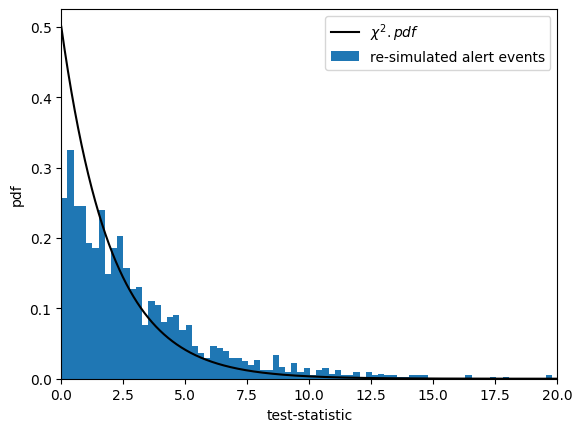

In [8]:
all = []
for event_id in succ_ids:
    if int(event_id) in starting_events:
        continue
    try:
        dat_filter_prepulse_corr = np.load(os.path.join(bp, "original", f"llh_results_event_{event_id}_padded_input.npy"))
    except:
        continue

    all.append( dat_filter_prepulse_corr[:, 0][np.isfinite(dat_filter_prepulse_corr[:, 0])] )

all = np.concatenate(all)

xvals = np.linspace(0.0, 20.0, 10000)
yvals = chi2.pdf(xvals, 2)
bins = np.linspace(0.0, 100, 400)
plt.figure()
plt.plot(xvals, yvals,  "k-", label = '$\chi^2.pdf$',)
plt.hist(all, density=True, bins=bins, label='re-simulated alert events')
plt.legend()
plt.ylabel('pdf')
plt.xlabel('test-statistic')
plt.xlim([0.0, 20])
plt.show()

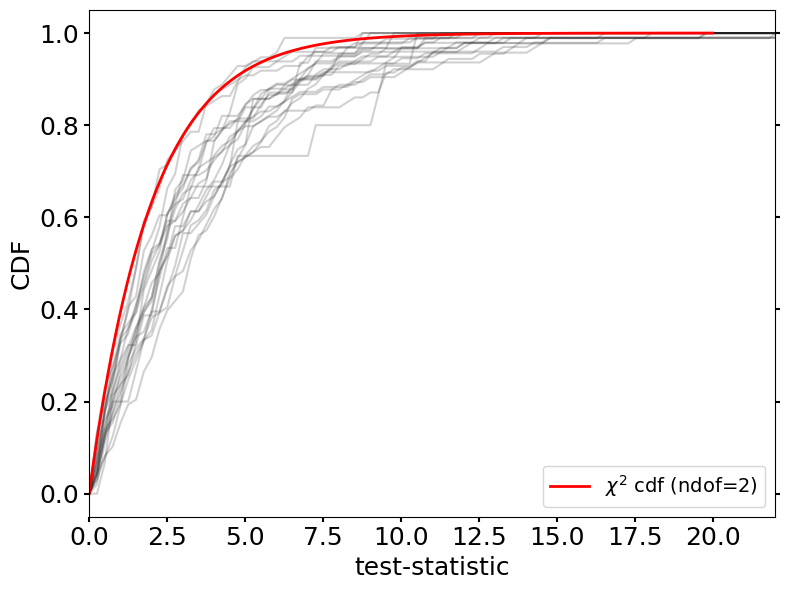

In [9]:
xvals = np.linspace(0.0, 20, 1000)
yvals = chi2.cdf(xvals, 2)
yvals2 = chi2.cdf(xvals, 3.5)

plt.figure(figsize=(8,6))

for cdf in cdfs_corr:
    plt.plot(bins, np.concatenate([np.array([0]), cdf]), alpha=0.2, color='0.1')
    #plt.hist(binc_plot, bins=bins_plot, weights=cdf, histtype='step', alpha=0.4)


plt.plot(xvals, yvals, 'r-', label='$\\chi^2$ cdf (ndof=2)', lw=2)
#plt.plot(xvals, yvals2, 'r--', label='$\\chi^2$ cdf (ndof=3.5)', lw=1)
plt.xlim([0.0, 22])
plt.legend(loc='lower right', fontsize=14)
plt.ylabel('CDF', fontsize=18)
plt.xlabel('test-statistic', fontsize=18)

ax = plt.gca()
#ax.axhline(y=0.9, color="tab:orange", linestyle='dotted', lw=1)
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [9]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.68
crit_vals = []
for cdf in cdfs_corr:
    i = bisect_left(cdf.tolist(), pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

In [13]:
print(search_bins.shape)

(399,)


In [14]:
print(cdf.shape)

(399,)


In [15]:
print(cdfs_corr[0].shape)

(399,)


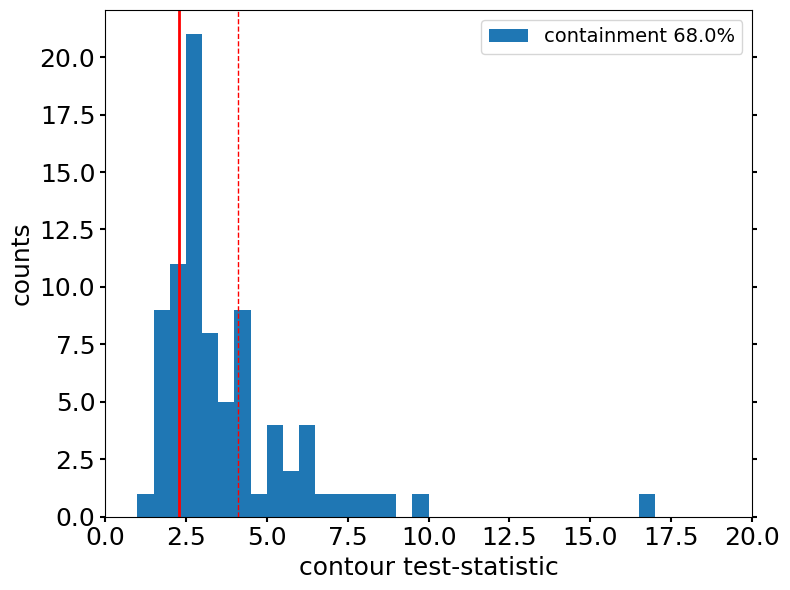

In [16]:
plt.figure(figsize=(8,6))
bins_c = np.linspace(0.0, 20.0, 41)
_, h1, b1 = plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 20])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [17]:
for s_id, crit_val in zip(succ_ids, crit_vals):
    if crit_val > 5:
        print(s_id)

10393
16416
1663
22510
24726
25181
28400
32781
33656
34506
37263
39166
55526
56041
59089
65472
8840


In [18]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.9
crit_vals = []
for cdf in cdfs_corr:
    i = bisect_left(cdf, pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    if x > 20:
        x = 20
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

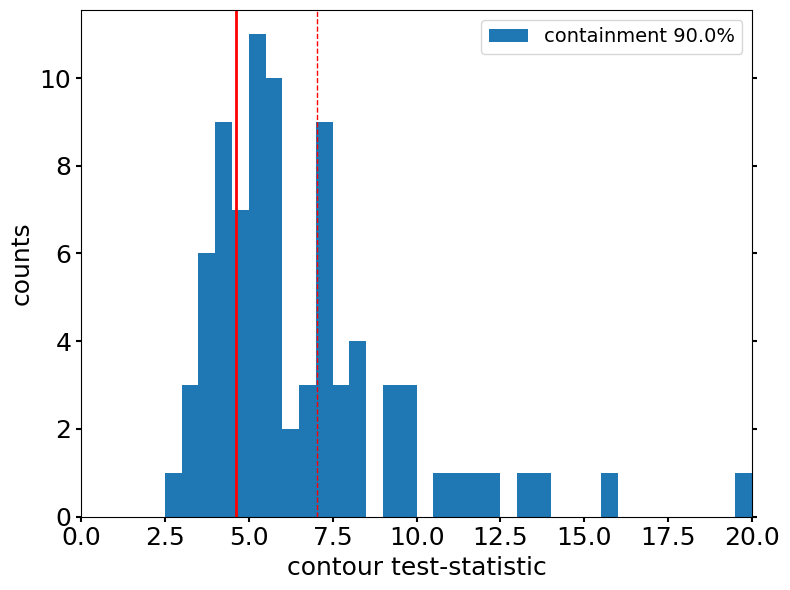

In [19]:
plt.figure(figsize=(8,6))
h1, b1, _ = plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 20])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [22]:
cdfs = []

for event_id in succ_ids:
    if int(event_id) in starting_events:
        continue
    try:
        dat_filter_prepulse_corr = np.load(os.path.join(bp, "filter_prepulse", f"llh_results_event_{event_id}_padded_input.npy"))
    except:
        continue

    cdf, _ = cdf_filter_prepulse_corr, m3 = get_hist(dat_filter_prepulse_corr, bins)
    cdfs.append(cdf)

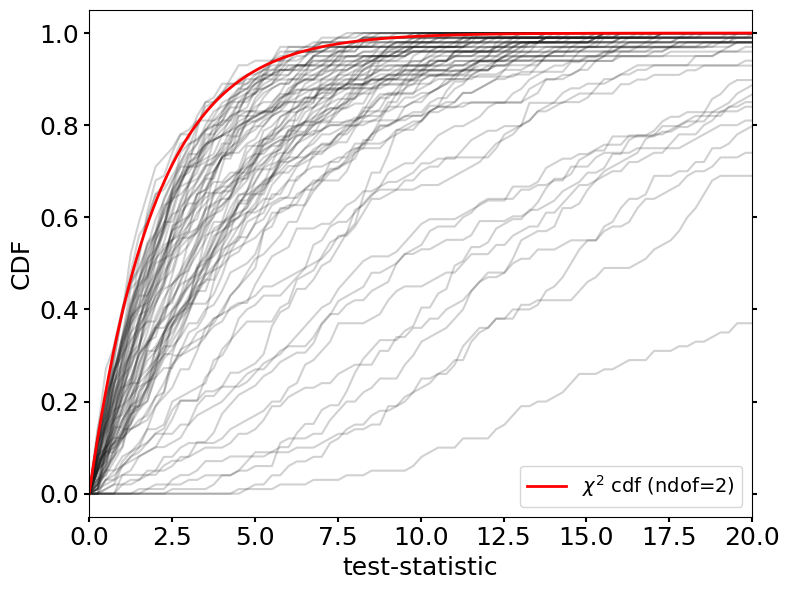

In [25]:
xvals = np.linspace(0.0, 20, 1000)
yvals = chi2.cdf(xvals, 2)
yvals2 = chi2.cdf(xvals, 3.5)

plt.figure(figsize=(8,6))

for cdf in cdfs:
    plt.plot(bins, np.concatenate([np.array([0]), cdf]), alpha=0.2, color='0.1')
    #plt.hist(binc_plot, bins=bins_plot, weights=cdf, histtype='step', alpha=0.4)


plt.plot(xvals, yvals, 'r-', label='$\\chi^2$ cdf (ndof=2)', lw=2)
#plt.plot(xvals, yvals2, 'r--', label='$\\chi^2$ cdf (ndof=3.5)', lw=1)
plt.xlim([0.0, 20])
plt.legend(loc='lower right', fontsize=14)
plt.ylabel('CDF', fontsize=18)
plt.xlabel('test-statistic', fontsize=18)

ax = plt.gca()
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [26]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.68
crit_vals = []
for cdf in cdfs:
    i = bisect_left(cdf, pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    if x > 20:
        x=20.0
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

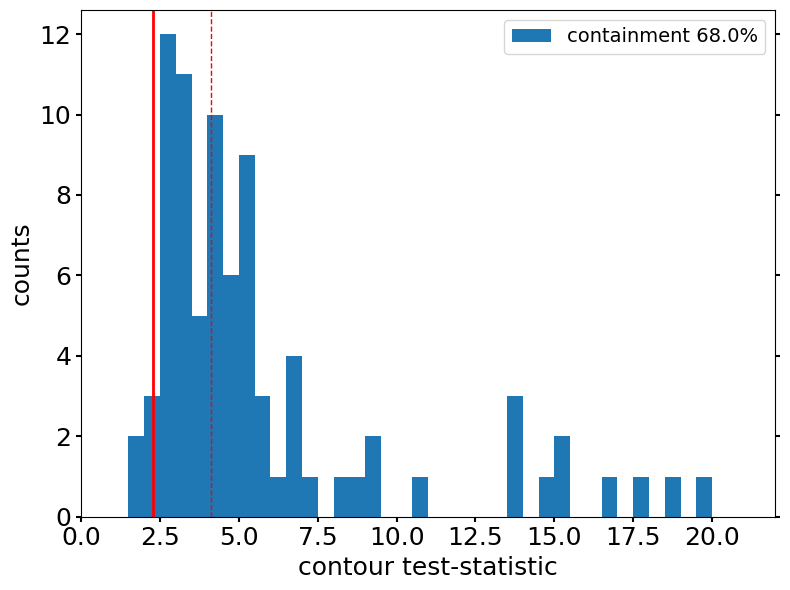

In [27]:
plt.figure(figsize=(8,6))
plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 22])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [28]:
from bisect import bisect_left
search_bins = bins[1:].copy()

pval = 0.9
crit_vals = []
for cdf in cdfs:
    i = bisect_left(cdf, pval)
    x = 0.5*(search_bins[i]+search_bins[i-1])
    if x > 20:
        x=20.0
    #print(0.5*(cdf[i]+cdf[i-1]))
    crit_vals.append(x)

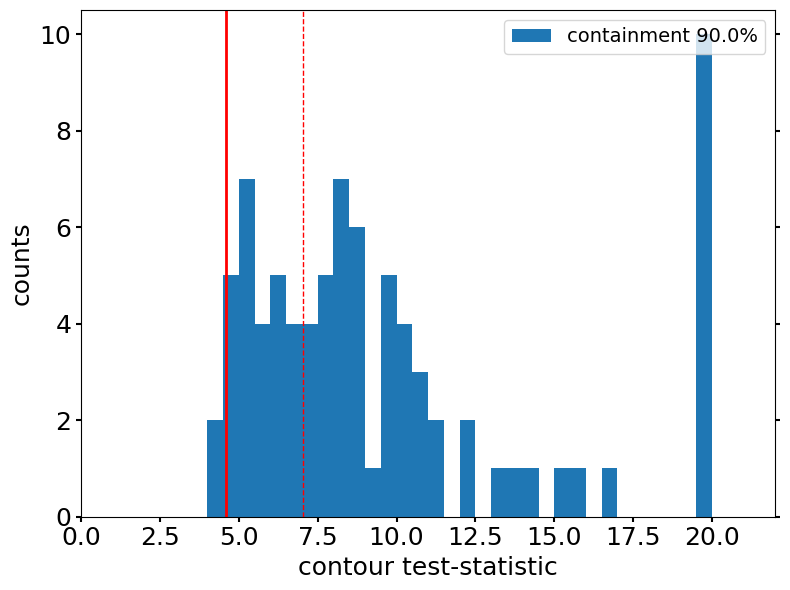

In [29]:
plt.figure(figsize=(8,6))
h2, b2, _ = plt.hist(crit_vals, bins=bins_c, label=f'containment {pval*100}%')
plt.xlim([0.0, 22])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('counts', fontsize=18)
plt.xlabel('contour test-statistic', fontsize=18)

ax = plt.gca()
ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.tight_layout()
plt.show()

In [11]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [31]:
gcds = []
gcds_corr = []
for event_id in succ_ids:
    dat_filter_prepulse = np.load(os.path.join(bp, "filter_prepulse", f"mincoords_event_{event_id}_padded_input.npy"))
    dat_filter_prepulse_corr = np.load(os.path.join(bp, "corrected", f"mincoords_event_{event_id}_padded_input.npy"))
    true = np.load(os.path.join(bp, "filter_prepulse", f"truecoords_event_{event_id}_padded_input.npy"))[0]
    true_zen, true_azi = true[0], true[1]
    reco_zen_corr, reco_azi_corr = dat_filter_prepulse_corr[:, 0], dat_filter_prepulse_corr[:, 1]
    reco_zen, reco_azi = dat_filter_prepulse[:, 0], dat_filter_prepulse[:, 1]
    gcd_corr = np.median(GreatCircleDistance(true_azi, true_zen, reco_azi_corr, reco_zen_corr))
    gcd = np.median(GreatCircleDistance(true_azi, true_zen, reco_azi, reco_zen))
    gcds.append(gcd)
    gcds_corr.append(gcd_corr)
    

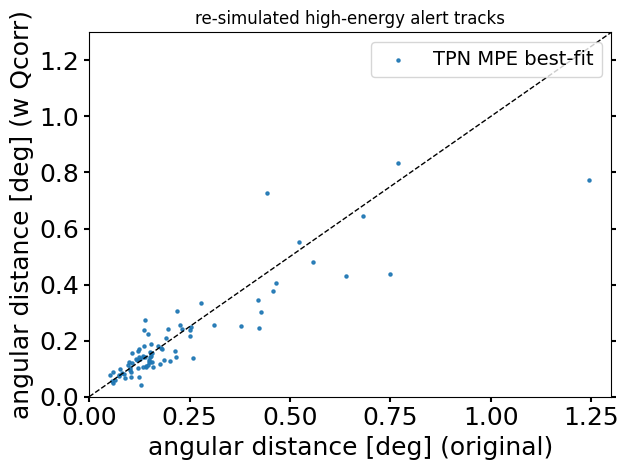

In [32]:
plt.figure()
plt.scatter(np.rad2deg(gcds), np.rad2deg(gcds_corr), s=5, alpha=0.9, label='TPN MPE best-fit')
plt.plot([0.0, 1.3], [0.0, 1.3], "k--", lw=1)
plt.ylim([0.0, 1.3])
plt.xlim([0.0, 1.3])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('angular distance [deg] (w Qcorr)', fontsize=18)
plt.xlabel('angular distance [deg] (original)', fontsize=18)

ax = plt.gca()
#ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
#ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.title('re-simulated high-energy alert tracks')
plt.tight_layout()
plt.show()

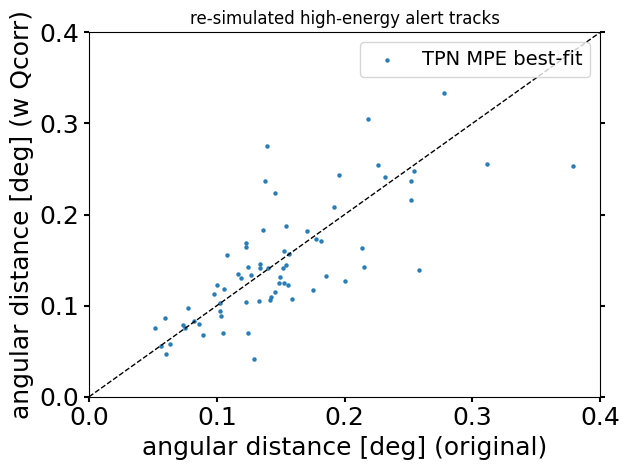

In [33]:
plt.figure()
plt.scatter(np.rad2deg(gcds), np.rad2deg(gcds_corr), s=5, alpha=0.9, label='TPN MPE best-fit')
plt.plot([0.0, 1.3], [0.0, 1.3], "k--", lw=1)
plt.ylim([0.0, 0.4])
plt.xlim([0.0, 0.4])
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('angular distance [deg] (w Qcorr)', fontsize=18)
plt.xlabel('angular distance [deg] (original)', fontsize=18)

ax = plt.gca()
#ax.axvline(x=chi2.isf(1-pval, 2), color='red', lw=2)
#ax.axvline(x=chi2.isf(1-pval, 3.5), color='red', lw=1, linestyle='dashed')
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.title('re-simulated high-energy alert tracks')
plt.tight_layout()
plt.show()

In [34]:
h1

array([ 0.,  0.,  0.,  0.,  0.,  1.,  3.,  6.,  9.,  7., 11., 10.,  2.,
        3.,  9.,  3.,  4.,  0.,  3.,  3.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.])

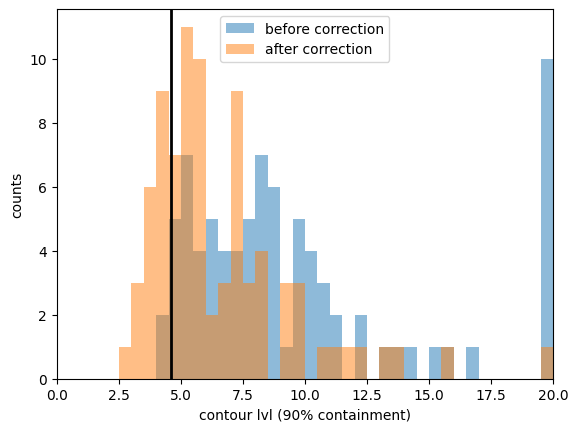

In [35]:
from scipy.stats import chi2

pval = 0.9
plt.figure()
bincc = 0.5 * (b1[:-1] + b1[1:])
plt.hist(bincc, bins=b2, weights=h2, alpha=0.5, label='before correction')
plt.hist(bincc, bins=b1, weights=h1, alpha=0.5, label='after correction')
plt.legend()
plt.ylabel('counts')
plt.xlabel('contour lvl (90% containment)')
plt.xlim([0.0, 20])
plt.axvline(x=chi2.isf(1-pval, 2), color='black', lw=2)
plt.show()

In [36]:
h1

array([ 0.,  0.,  0.,  0.,  0.,  1.,  3.,  6.,  9.,  7., 11., 10.,  2.,
        3.,  9.,  3.,  4.,  0.,  3.,  3.,  0.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.])

In [37]:
b1

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. ])

0.9428171152379529


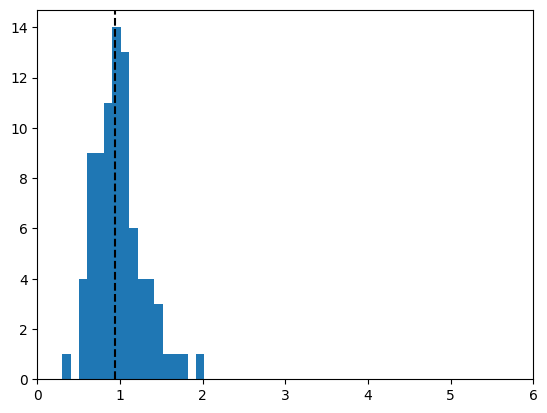

In [38]:
bins = np.linspace(0.0, 10.0, 100)
plt.hist(np.rad2deg(gcds_corr) / np.rad2deg(gcds), bins=bins)
plt.xlim([0.0, 6.0])
plt.axvline(x = np.median(np.rad2deg(gcds_corr) / np.rad2deg(gcds)), color = 'k', linestyle='dashed')
print(np.median(np.rad2deg(gcds_corr) / np.rad2deg(gcds)))

/tmp/ipykernel_79186/1460349544.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right', fontsize=14)


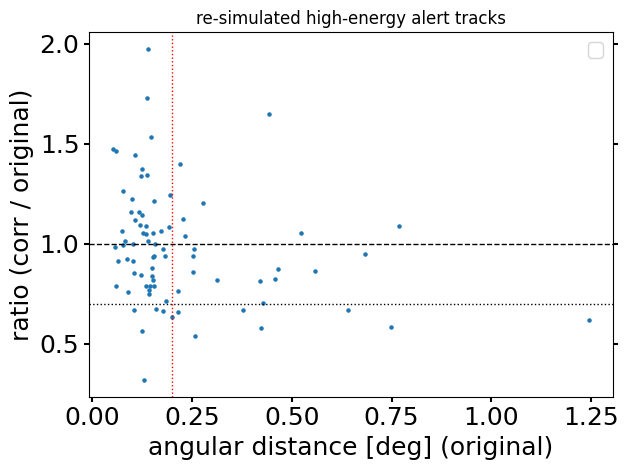

In [39]:
plt.figure()
plt.scatter(np.rad2deg(gcds), np.rad2deg(gcds_corr) / np.rad2deg(gcds), s=5)
plt.axhline(y=1, linestyle='dashed', color='k', linewidth=1)
plt.axhline(y=0.7, linestyle='dotted', color='k', linewidth=1)
plt.axvline(x=0.2, linestyle='dotted', color='r' ,linewidth=1)
plt.legend(loc='upper right', fontsize=14)
plt.ylabel('ratio (corr / original)', fontsize=18)
plt.xlabel('angular distance [deg] (original)', fontsize=18)

ax = plt.gca()
ax.tick_params(axis='both', which='both', width=1.5, colors='0.0', labelsize=18)
ax.yaxis.set_ticks_position('both')
plt.title('re-simulated high-energy alert tracks')
plt.tight_layout()
plt.show()

In [40]:
ct = 0
for i in range(len(gcds)):
    if gcds[i] > gcds_corr[i]:
        ct += 1

In [41]:
print(ct / len(gcds))

0.5853658536585366


In [42]:
ct1 = 0
ct2 = 0
for i in range(len(gcds)):
    if gcds[i] < 0.9 * gcds_corr[i]:
        ct1 += 1
    if gcds_corr[i] < 0.9 * gcds[i]:
        ct2 += 1

In [43]:
print(ct1, ct2, len(gcds))

21 34 82


0.1420711835729853
[0.1027174  0.13165991 0.16731093 0.25397007]


(0.0, 30.0)

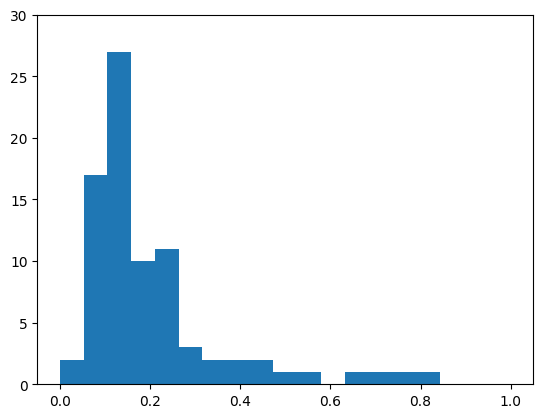

In [44]:
plt.hist(np.rad2deg(gcds_corr), bins=np.linspace(0.0, 1.0, 20))
print(np.rad2deg(np.median(gcds_corr)))
print(np.percentile(np.rad2deg(gcds_corr), [20, 40, 60, 80]))
plt.ylim(ymax=30)

In [45]:
gcds = []
gcds_corr = []
for event_id in succ_ids:
    dat_filter_prepulse_corr = np.load(os.path.join(bp, "corrected", f"mincoords_event_{event_id}_padded_input.npy"))
    true = np.load(os.path.join(bp, "filter_prepulse", f"truecoords_event_{event_id}_padded_input.npy"))[0]
    true_zen, true_azi = true[0], true[1]
    reco_zen_corr, reco_azi_corr = dat_filter_prepulse_corr[:, 0], dat_filter_prepulse_corr[:, 1]
    gcd_corr = np.percentile(GreatCircleDistance(true_azi, true_zen, reco_azi_corr, reco_zen_corr), [16, 50, 84])
    gcds_corr.append(gcd_corr)

82


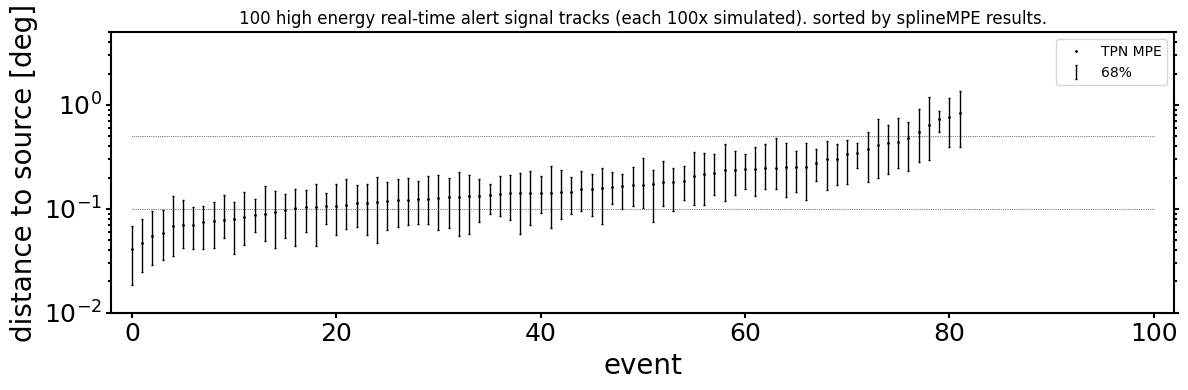

In [46]:
tpn_mpe_v = np.rad2deg(gcds_corr)
n = len(tpn_mpe_v)

fig, ax = plt.subplots(figsize=(12,4))
#x = np.array(list(range(99)))
x = np.array(list(range(n)))
y = np.array([t[1] for t in tpn_mpe_v])

print(len(y[y>0.01]))



idx = np.argsort(y)
y = y[idx]
y_err_up = np.array([t[2] for t in tpn_mpe_v])[idx] - y
y_err_low = y - np.array([t[0] for t in tpn_mpe_v])[idx]

#y_err_up = np.array([t[2] for t in tpn_mpe_v]) - y
#y_err_low = y - np.array([t[0] for t in tpn_mpe_v])


ax.errorbar(x, y, yerr=[y_err_low, y_err_up], capsize=1, linewidth=0, elinewidth=1, color='black', label='68%')
ax.plot(x, y, "ko", markersize=1, label='TPN MPE')

ax.set_yscale('log')
ax.plot([0.0, 100.0], [0.5, 0.5], linestyle='dotted', lw=0.5, color='k')
ax.plot([0.0, 100.0], [0.1, 0.1], linestyle='dotted', lw=0.5, color='k')

plot_args = {'xlabel':'event', 
                 'ylabel':'distance to source [deg]', 
                 'xlim':[-2.0, 102], 
                 'ylim':[0.01, 5]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_title("100 high energy real-time alert signal tracks (each 100x simulated). sorted by splineMPE results.")
plt.tight_layout()
plt.show()

In [12]:
gcds = []
gcds_corr = []
for event_id in succ_ids:
    dat_filter_prepulse_corr = np.load(os.path.join(bp, "original", f"mincoords_event_{event_id}_padded_input.npy"))
    true = np.load(os.path.join(bp, "original", f"truecoords_event_{event_id}_padded_input.npy"))[0]
    s_mpe = np.load(os.path.join(bp, "original", f"splinempecoords_event_{event_id}_padded_input.npy"))
    true_zen, true_azi = true[0], true[1]
    reco_zen_corr, reco_azi_corr = dat_filter_prepulse_corr[:, 0], dat_filter_prepulse_corr[:, 1]
    gcd_corr = np.percentile(GreatCircleDistance(true_azi, true_zen, reco_azi_corr, reco_zen_corr), [16, 50, 84])
    gcds_corr.append(gcd_corr)

    smpe_zen, smpe_azi = s_mpe[:, 0], s_mpe[:, 1]
    gcd = np.percentile(GreatCircleDistance(true_azi, true_zen, smpe_azi, smpe_zen), [16, 50, 84])
    gcds.append(gcd)
    

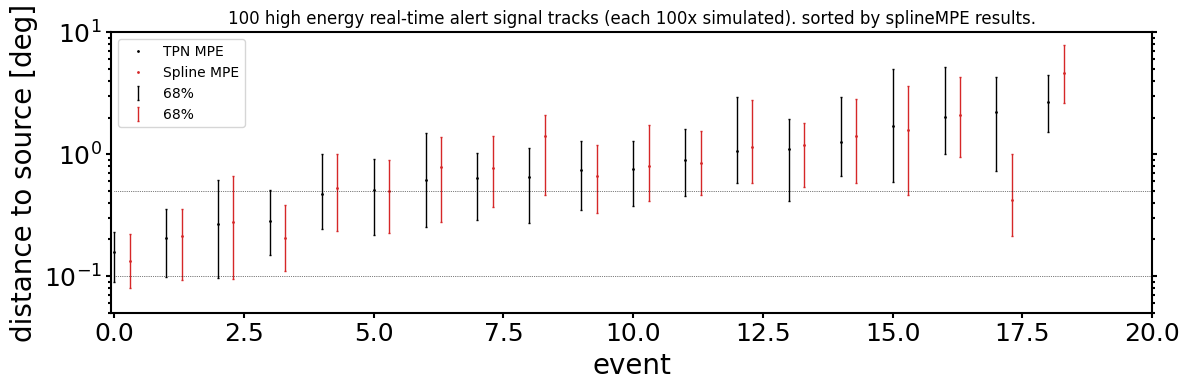

In [28]:
tpn_mpe_v = np.rad2deg(gcds_corr)
smpe_v = np.rad2deg(gcds)
n = len(tpn_mpe_v)

fig, ax = plt.subplots(figsize=(12,4))
#x = np.array(list(range(99)))
x = np.array(list(range(n)))
y = np.array([t[1] for t in tpn_mpe_v])
z = np.array([t[1] for t in smpe_v])

idx = np.argsort(y)
y = y[idx]
z = z[idx]
y_err_up = np.array([t[2] for t in tpn_mpe_v])[idx] - y
y_err_low = y - np.array([t[0] for t in tpn_mpe_v])[idx]


z_err_up = np.array([t[2] for t in smpe_v])[idx] - z
z_err_low = z - np.array([t[0] for t in smpe_v])[idx]


ax.errorbar(x, y, yerr=[y_err_low, y_err_up], capsize=1, linewidth=0, elinewidth=1, color='black', label='68%')
ax.plot(x, y, "ko", markersize=1, label='TPN MPE')

ax.errorbar(x+0.3, z, yerr=[z_err_low, z_err_up], capsize=1, linewidth=0, elinewidth=1, color='tab:red', label='68%')
ax.plot(x+0.3, z,  color='tab:red', marker='o', markersize=1, label='Spline MPE', linewidth=0)

ax.set_yscale('log')
ax.plot([0.0, 100.0], [0.5, 0.5], linestyle='dotted', lw=0.5, color='k')
ax.plot([0.0, 100.0], [0.1, 0.1], linestyle='dotted', lw=0.5, color='k')

plot_args = {'xlabel':'event', 
                 'ylabel':'distance to source [deg]', 
                 'xlim':[-0.05, 20], 
                 'ylim':[0.05, 10]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_title("100 high energy real-time alert signal tracks (each 100x simulated). sorted by splineMPE results.")
plt.tight_layout()
plt.show()

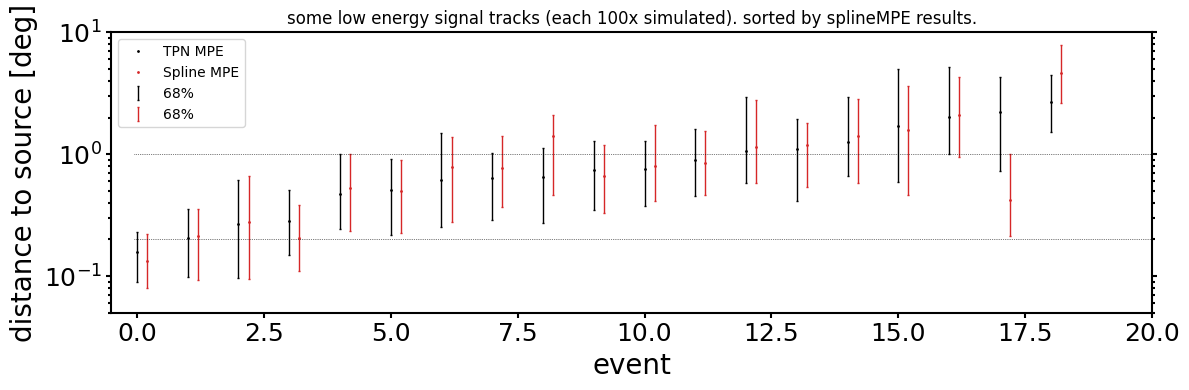

In [29]:
tpn_mpe_v = np.rad2deg(gcds_corr)
smpe_v = np.rad2deg(gcds)
n = len(tpn_mpe_v)

fig, ax = plt.subplots(figsize=(12,4))
#x = np.array(list(range(99)))
x = np.array(list(range(n)))
y = np.array([t[1] for t in tpn_mpe_v])
z = np.array([t[1] for t in smpe_v])

idx = np.argsort(y)
y = y[idx]
z = z[idx]
y_err_up = np.array([t[2] for t in tpn_mpe_v])[idx] - y
y_err_low = y - np.array([t[0] for t in tpn_mpe_v])[idx]


z_err_up = np.array([t[2] for t in smpe_v])[idx] - z
z_err_low = z - np.array([t[0] for t in smpe_v])[idx]


ax.errorbar(x, y, yerr=[y_err_low, y_err_up], capsize=1, linewidth=0, elinewidth=1, color='black', label='68%')
ax.plot(x, y, "ko", markersize=1, label='TPN MPE')

ax.errorbar(x+0.2, z, yerr=[z_err_low, z_err_up], capsize=1, linewidth=0, elinewidth=1, color='tab:red', label='68%')
ax.plot(x+0.2, z,  color='tab:red', marker='o', markersize=1, label='Spline MPE', linewidth=0)

ax.set_yscale('log')
ax.plot([-0.05, 100.0], [0.2, 0.2], linestyle='dotted', lw=0.5, color='k')
ax.plot([-0.05, 100.0], [1.0, 1.0], linestyle='dotted', lw=0.5, color='k')

plot_args = {'xlabel':'event', 
                 'ylabel':'distance to source [deg]', 
                 'xlim':[-0.5, 20], 
                 'ylim':[0.05, 10]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_title("some low energy signal tracks (each 100x simulated). sorted by splineMPE results.")
plt.tight_layout()
plt.show()

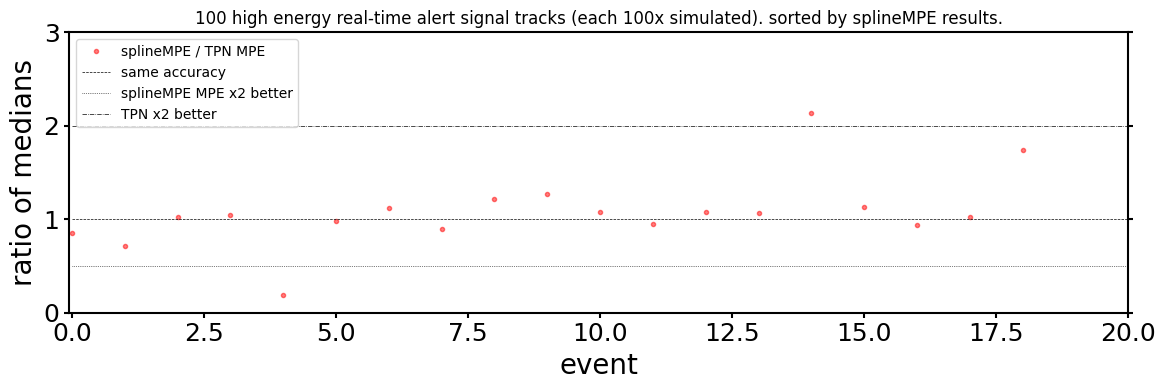

In [25]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(x, z/y, "ro", markersize=3, alpha=0.5, label='splineMPE / TPN MPE')
ax.plot([0.0, 100.0], [1.0, 1.0], linestyle='dashed', color='k', lw=0.5, label='same accuracy')
ax.plot([0.0, 100.0], [0.5, 0.5], linestyle='dotted', color='k', lw=0.5, label='splineMPE MPE x2 better')
ax.plot([0.0, 100.0], [2.0, 2.0], linestyle='dashdot', color='k', lw=0.5, label='TPN x2 better')
plot_args = {'xlabel':'event', 
                 'ylabel':'ratio of medians', 
                 'xlim':[-0.05, 20], 
                 'ylim':[0.0, 3.0]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
ax.set_title("100 high energy real-time alert signal tracks (each 100x simulated). sorted by splineMPE results.")
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()